<a href="https://colab.research.google.com/github/elizathornton/WiBD-Disaster-Tweets-Project/blob/main/Disaster_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('all')

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

!pip install neattext
from neattext.pipeline import TextPipeline
from neattext.functions import  remove_emails, fix_contractions, remove_numbers,remove_emojis,remove_special_characters, remove_stopwords, remove_html_tags, remove_urls, remove_puncts,remove_custom_pattern


import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

from keras.models import Sequential
from keras.layers import Dense

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#read in the tweets
df = pd.read_csv('/content/drive/My Drive/WiBD/data/train.csv')


# remove the columns keyword and location
df.drop(['keyword','location'],axis=1,inplace=True)


In [ ]:
#  TO DO 
# consider changing the cleaning process:
# removely only the hashtag from tags and separate the words
# fix spelling.
 # then remove stop words

 


In [ ]:
def clean(text):

    text = text.lower() # make it all lower case
    text = re.sub(r'\n', '', text) # take out any line breaks
  

    specific_cleaning = TextPipeline(steps=[remove_numbers, fix_contractions, 
                                            remove_stopwords, remove_emails,remove_emojis, 
                                            remove_html_tags, remove_urls, remove_special_characters])
    
    text = specific_cleaning.transform(text)

 
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [ ]:
# apply the "clean" function to the data frame, and put the cleaned text in a new column
df['clean_text'] = df['text'].map(clean)
# Remove duplicate texts AFTER removing @'s, web addresses,  and non-word characthers
df = df.drop_duplicates(subset='text', keep="first")


In [ ]:
df.head()

,id,text,target,clean_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


# Tokenize the text

In [ ]:
sentences = [nltk.word_tokenize(sent) for sent in df['clean_text']]

# Vectorization
Let's try and compare 2 different different vectorization techniques:

1) Word2vec

2) TFIDF

I'm going to split the dataset into train/ test data and then vectorize it 2 different ways - Word2Vec  (which hopefully will find relationships between words to be able to classify words used to describe disasters based on the training data) and TFIDF (which uses word frequencies to find which words are important in determining if a text is about disasters)

In [ ]:

#In this section we will split up the data into test and train and vectorize it 2 different ways

#split up the data into train / test
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['target'] , test_size=0.2)

# Train the word2vec model

w2v_model = gensim.models.Word2Vec(sentences,
                                   vector_size=100, 
                                   window=5,
                                   min_count=2)
words = set(w2v_model.wv.index_to_key )

#vectorize the X_train and X_test data with word2vec
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])


# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_w2v = []
for v in X_train_vect:
    if v.size:
        X_train_w2v.append(v.mean(axis=0))
    else:
        X_train_w2v.append(np.zeros(100, dtype=float))
        
X_test_w2v = []
for v in X_test_vect:
    if v.size:
        X_test_w2v.append(v.mean(axis=0))
    else:
        X_test_w2v.append(np.zeros(100, dtype=float))

# vectorize the train / test data with tfidf

tfidf_vectorizer = TfidfVectorizer(max_features=1000) # put in max features? 
vectorized_sentences = tfidf_vectorizer.fit(X_train)
X_train_tfidf  = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



#tfidf_vect = TfidfVectorizer(max_features=5000)
#tfidf_vect.fit(x_train)

#x_train_tfidf = tfidf_vect.transform(x_train)
#x_val_tfidf = tfidf_vect.transform(x_val)


<ipython-input-6-fa0eb9220c46>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-6-fa0eb9220c46>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [ ]:
print(words)

{'woman', 'fema', 'town', 'your', 'transformed', 'le', 'forgotten', 'hatred', 'tribune', 'freefrom', 'pharaoh', 'fall', 'hollywood', 'ice', 'internet', 'mate', 'bullseye', 'need', 'f', 'stranded', 'stagetwo', 'cld', 'thetwister', 'batter', 'shooting', 'bicyclist', 'customer', 'ad', 'cage', 'drawn', 'wftv', 'olap', 'duke', 'ebike', 'wine', 'fury', 'tuning', 'breaking', 'shell', 'floated', 'feeding', 'vault', 'closed', 'alot', 'cnn', 'meteoearth', 'uh', 'exterminate', 'casper', 'durant', 'classic', 'acoustic', 'reading', 'technica', 'rank', 'clev', 'short', 'related', 'rose', 'cut', 'corey', 'unlocking', 'vashon', 'fox', 'invoice', 'si', 'zaynmalik', 'condemn', 'jenner', 'croatian', 'holmgren', 'appreciate', 'act', 'limit', 'kurtschlichter', 'o', 'caribbean', 'wash', 'zabadani', 'called', 'action', 'creating', 'pov', 'landing', 'rover', 'corner', 'pjnet', 'politifiact', 'forex', 'vabengal', 'coming', 'wipp', 'penny', 'salvador', 'radar', 'rained', 'odds', 'led', 'kerricktrial', 'aba', 'b

# Comparing Models:
I'm choosing models commonly used for supervised classification:
- Logistic Regression
- Decision Tree
- Support Vector
- Naive Bayes
- KNN
- Random Forest
- Gradient Boosted

I'm going to make a data frame with rows (index) a list of the different types of models  and columns: y_pred and accuracy score

In [ ]:
models = { 'Logistic Regression': LogisticRegression(), 
          'Decision Tree': DecisionTreeClassifier(),
          'Support Vector': SVC(),
          'Naive Bayes': GaussianNB(),
          'KNN': KNeighborsClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Gradient Boosted':GradientBoostingClassifier()}
              

In [ ]:
results  = pd.DataFrame(index = models.keys(), columns = 
                        ['w2v predicted','w2v accuracy','tfidf predicted','tfidf accuracy'])
results.head()

,w2v predicted,w2v accuracy,tfidf predicted,tfidf accuracy
Logistic Regression,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN
Support Vector,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN


In [ ]:

# step through each of the models, and run it to find the  y_predicted and the accuracy score
for key in models:
  mod = models[key]
  model_w2v = mod.fit(X_train_w2v,y_train.values.ravel())

  # find predictions for the test data on each model 
  y_pred_w2v = model_w2v.predict(X_test_w2v)
  accuracy_w2v = accuracy_score(y_test, y_pred_w2v)

  #put the results into the results dataframe
  results.at[key, 'w2v predicted'] = y_pred_w2v 
  results.at[key, 'w2v accuracy'] = accuracy_w2v 





In [ ]:
for key in models:
  mod = models[key]
  model_tfidf = mod.fit(X_train_tfidf.toarray(),y_train.values.ravel())

  # find predictions for the test data on each model using each vectorization
  y_pred_tfidf = model_tfidf.predict(X_test_tfidf.toarray())
  accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

  #put the results into the results dataframe
  results.at[key, 'tfidf predicted'] = y_pred_tfidf
  results.at[key, 'tfidf accuracy'] = accuracy_tfidf 




In [ ]:
results.head()


,w2v predicted,w2v accuracy,tfidf predicted,tfidf accuracy
Logistic Regression,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.567622,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.803464
Decision Tree,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",0.560959,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.741506
Support Vector,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.57495,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.79547
Naive Bayes,"[0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...",0.542971,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.759494
KNN,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",0.596935,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.711526


<ipython-input-12-dc162473cea1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(results.index, rotation=45)


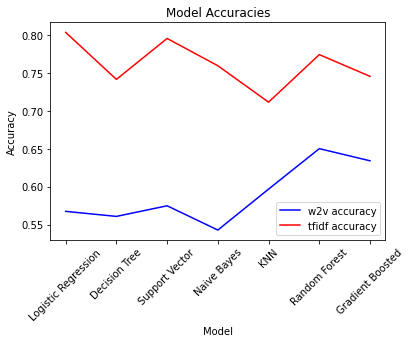

In [ ]:


# create a figure and axis object
fig, ax = plt.subplots()

# plot the w2v accuracy line
ax.plot(results.index, results['w2v accuracy'], color='blue', label='w2v accuracy')

# plot the tfidf accuracy line
ax.plot(results.index, results['tfidf accuracy'], color='red', label='tfidf accuracy')

# add axis labels and title
ax.set_xticklabels(results.index, rotation=45)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies')

# add a legend
ax.legend()

# display the plot
plt.show()


In [ ]:
print(X_train_w2v.toarray().shape)
print(y_train.shape)
#print(y_train)


AttributeError: ignored

In [ ]:


# define the model
model = Sequential()
model.add(Dense(10, input_dim=100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_test_tfidf, y_test))

# evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')


Epoch 1/10


ValueError: ignored

In [ ]:
df_comparison = pandas.DataFrame()
df_comparison.set_index

In [ ]:
# this is a function that takes in a list of sentences ( X_train or X_test) and returns a list of vectors
# vectorized with word2vec.  You also need to pass the trained w2v_model and the list of words
def w2v(sentence_data,w2v_model, words):
  vectorized_words = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in sentence_data])


# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
  vectorized_sentences = []
  for v in vectorized_words:
    if v.size:
        vectorized_sentences.append(v.mean(axis=0))
    else:
        vectorized_sentences.append(np.zeros(100, dtype=float))
        
  return vectorized_sentences


In [ ]:
#split up the data into train / test
X_train, X_test, y_train, y_test = train_test_split (df['clean_text'], df['target'] , test_size=0.2)

# Train the word2vec model
w2v_model = gensim.models.Word2Vec(sentences,
                                   vector_size=100, 
                                   window=5,
                                   min_count=2)
words = set(w2v_model.wv.index_to_key )


X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])


# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))


# Instantiate and fit a basic Random Forest model on top of the vectors

#rf = RandomForestClassifier()
rf = LogisticRegression()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)


#accuracy_score(predictions, y_val)*100
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

<ipython-input-9-5fe4f5056ced>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-9-5fe4f5056ced>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


Precision: 0.396 / Recall: 0.03 / Accuracy: 0.572


In [ ]:
        models = [
              LogisticRegression(),
              DecisionTreeClassifier(),
              GradientBoostingClassifier(),
              sklearn.naive_bayes.MultinomialNB(), 
              sklearn.linear_model.LogisticRegression(),
              sklearn.svm.SVC(),
              sklearn.svm.SVC(C=10),
              sklearn.svm.SVC(C=0.5),
            ]

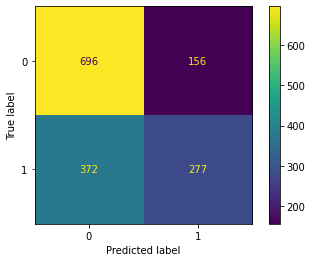

In [ ]:

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
#plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)
#plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_model = tfidf_vectorizer.fit_transform(df['clean_text']).toarray()
tfidf_model

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# this is a function that takes a list of sentences ( X_train or X_test) and returns a list of vectors
# vectorized with TFIDF
def tfidf(sentence_data):

  tfidf_vectorizer = TfidfVectorizer()
  vectorized_sentences = tfidf_vectorizer.fit_transform(sentence_data).toarray()
  return vectorized_sentences


In [ ]:

X_train, X_test, y_train, y_test = train_test_split (df['clean_text'], df['target'] , test_size=0.2)

# Train the word2vec model
w2v_model = gensim.models.Word2Vec(sentences =X_train,
                                   vector_size=100, 
                                   window=5,
                                   min_count=2)

words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])


# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))


# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)


from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

<ipython-input-15-5537f43bc9e1>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-15-5537f43bc9e1>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


Precision: 0.653 / Recall: 0.455 / Accuracy: 0.649


In [ ]:
print(words)

{'row', 'conservative', 'right', 'boy', 'bit', 'divided', 'woman', 'ready', 'reopening', 'journalist', 'exercised', 'loseit', 'k', 'crossed', 'beneath', 'horizon', 'brunette', 'okanagan', 'pkwy', 'looting', 'contain', 'latimes', 'instantly', 'minion', 'stephen', 'grandeur', 'spill', 'charles', 'pocket', 'blvd', 'driven', 'lamp', 'ev', 'robotrainstorm', 'turbine', 'i', 'cawx', 'wounded', 'herself', 'fence', 'cant', 'referring', 'appreciate', 'drag', 'jet', 'africa', 'ta', 'penn', 'surrounding', 'predicted', 'oct', 'sunk', 'fuckin', 'tripledigit', 'spent', 'journalism', 'union', 'modi', 'this', 'ima', 'year', 'technique', 'course', 'saw', 'go', 'danger', 'slipped', 'picking', 'catching', 'parole', 'kid', 'collins', 'displace', 'karymsky', 'worried', 'socialnews', 'rockbottomradfm', 'them', 'hahah', 'stu', 'teaching', 'out', 'renison', 'rail', 'plague', 'making', 'study', 'chocolate', 'amageddon', 'thankful', 'plan', 'playstation', 'bee', 'fog', 'flooded', 'pt', 'fucked', 'rly', 'protecti

In [ ]:
print(gensim.__version__)

4.3.0


In [ ]:
# this is the next jumbled section
# Instantiate and fit a basic Random Forest model on top of the vectors

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)


rf_model = RandomForestClassifier().fit(X_train_w2v,y_train)
#rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_w2v)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split (df['clean_text'], df['target'] , test_size=0.2)

# Train the word2vec model
w2v_model = gensim.models.Word2Vec(sentences,
                                   vector_size=100, 
                                   window=5,
                                   min_count=2)
words = set(w2v_model.wv.index_to_key )


# vectorize the X_train and X_test data in both word2vec and TFIDF
X_train_w2v = w2v(X_train, w2v_model, words)
X_test_w2v  = w2v(X_test, w2v_model, words)

X_train_tfidf = tfidf(X_train)
X_test_tfidf  = tfidf(X_test)




<ipython-input-10-5e593157fa75>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vectorized_words = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
